In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix
)
from bold_dementia.utils.iterables import unique

ATLAS = "gillig"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)


In [2]:
expname = f"atlas-{ATLAS}_default_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig_default_ols-cenanom


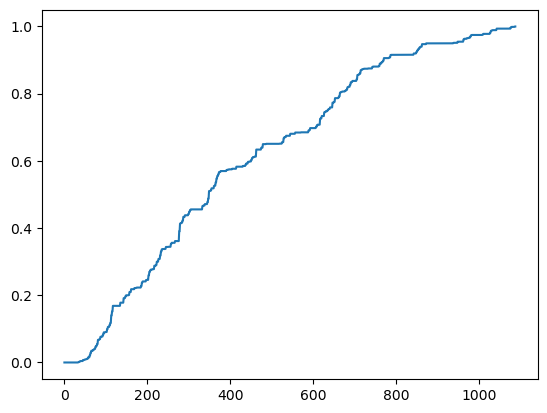

In [3]:
plt.plot(np.sort(fdrmat.flatten()))
plt.show()

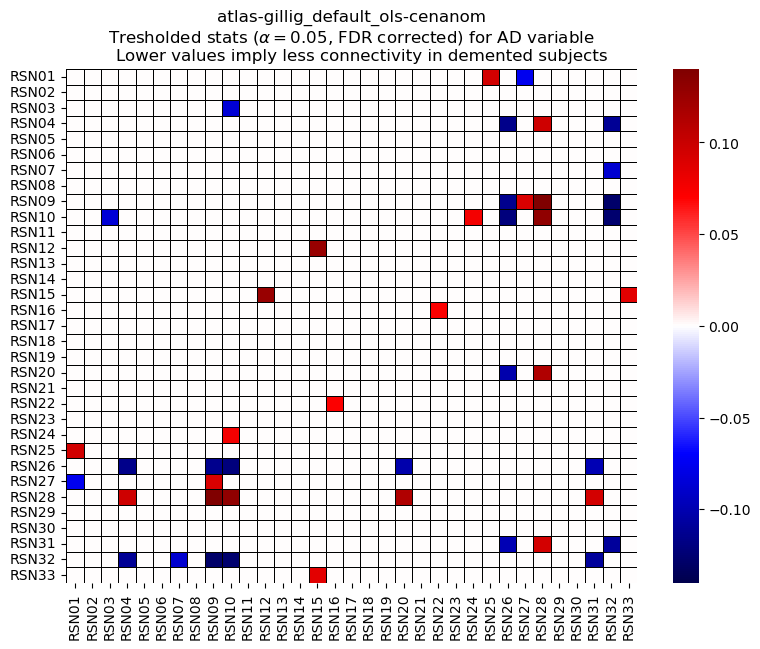

In [4]:
span = np.max(np.abs(thresholded_t))

if len(atlas.labels) < 35:
    plot_ordered_matrix(thresholded_t, atlas)
else:
    plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [5]:
if ATLAS != "gillig":
    coords = atlas.get_coords()
    plotting.plot_connectome(
        thresholded_t, coords
    )
else:
    print("Not so iteresting to compute mass centers of networks obviously")


Not so iteresting to compute mass centers of networks obviously


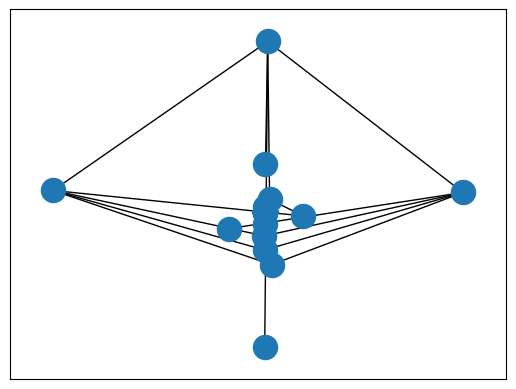

In [6]:
import networkx as nx

G = nx.from_numpy_array(thresholded_t, edge_attr="weight")

label_mapping = dict(zip(range(len(atlas.labels)), atlas.labels))

#pos = nx.spring_layout(G, seed=config["seed"], iterations=100)
pos = nx.spectral_layout(G)

nx.draw_networkx_nodes(G, pos)

nx.draw_networkx_edges(
    G,
    pos,
    edge_cmap="seismic"
)

#nx.draw_networkx_labels(
#    G,
#    pos,
#    font_size=8,
#    labels=label_mapping,
#)
plt.draw()

In [11]:
import math
labels = atlas.labels_
matrix_df = pd.DataFrame(thresholded_t, index=labels, columns=labels)

links = []
msk = []

for source, row in matrix_df.iterrows():
    for target_rsn, val in row.items():
        if val > 0:
            colour = "red"
        elif val < 0:
            colour = "blue"
        elif val == 0:
            continue
            
        offset = int(math.floor(10 * val))
        assert offset < 10
        links.append(
            (
                (source, 5 - offset // 2, 5 + offset // 2),
                (target_rsn, 5 - offset, 5 + offset),
                colour
            )
        )

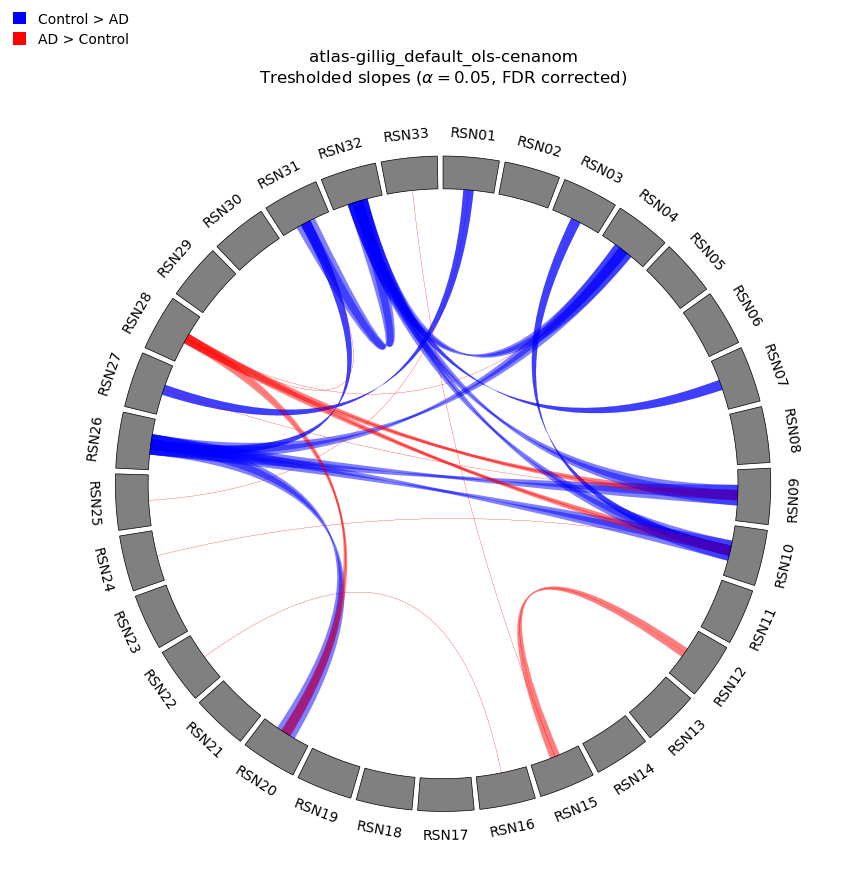

In [14]:
from pycirclize import Circos
import matplotlib.patches as mpatches

networks = matrix_df.columns.to_list()
sectors = {n: 10 for n in networks}
circos = Circos(sectors, space=1)

cmap="gray",
link_cmap=links,
ticks_kws={"label_size": 2},
r_lim=(90, 100)
# TODO Name to color
for sector in circos.sectors:
    # Plot label, outer track axis & xticks
    sector.text(sector.name)
    outer_track = sector.add_track(r_lim)
    color = "gray"
    outer_track.axis(fc=color)


# Plot links
for link in links:
    circos.link(*link[:2], color=link[2])

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

fig = circos.plotfig()
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)
fig.show()